In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
house_train_data = pd.read_csv('train.csv')
house_test_data = pd.read_csv('test.csv')

In [22]:
house_train_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [23]:
house_train_data.shape

(1460, 81)

In [24]:
house_train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = house_train_data.SalePrice              
X = house_train_data.drop(['SalePrice'], axis=1)

In [25]:
house_train_data.shape

(1460, 81)

In [26]:
house_test_data.shape

(1459, 80)

In [27]:
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [28]:
category_cols = [cols for cols in X_train_full.columns if X_train_full[cols].nunique() < 10 and X_train_full[cols].dtype=='object']
number_cols = [cols for cols in X_train_full.columns if X_train_full[cols].dtype in ['int64','float64']]

my_cols = category_cols + number_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = house_test_data[my_cols].copy()

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

number_transformer = SimpleImputer(strategy='mean')

category_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num',number_transformer,number_cols),('category',category_transformer,category_cols)])


In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',rf_model)])

In [31]:
my_pipeline.fit(X_train, y_train)

val_pred = my_pipeline.predict(X_valid)

print('MAE =',mean_absolute_error(y_valid, val_pred))



MAE = 17721.08506849315


In [32]:
test_pred = my_pipeline.predict(X_test)


In [33]:
from sklearn.model_selection import cross_val_score

score = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring ='neg_mean_absolute_error')

print('Average cross valuation score:',score.mean())

Average cross valuation score: 17708.780691780827


In [34]:
#def val_score_estimator(est):
#    model = RandomForestRegressor(n_estimators=est, random_state=0)
#    my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
#    scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring ='neg_mean_absolute_error')
#    return scores.mean()
    

#estimators = [100,200,300,400,500]
#val_scores = {}

#for i in estimators:
#    val_scores[i] = val_score_estimator(i)
#print(val_scores)


In [35]:
def final_model(est):
    model = RandomForestRegressor(n_estimators=est, random_state=0)
    my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
    my_pipeline.fit(X_train, y_train)
    pred = my_pipeline.predict(X_valid)
    return mean_absolute_error(y_valid, pred)

print('MAE=',final_model(300))

MAE= 17534.869417808215


In [56]:
from xgboost import XGBRegressor
import xgboost as xgb

X_train_xg = pd.get_dummies(X_train)
X_valid_xg = pd.get_dummies(X_valid)
X_test_xg = pd.get_dummies(X_test)
X_train_xg, X_valid_xg = X_train_xg.align(X_valid_xg, join='left', axis=1)
X_train_xg, X_test_xg = X_train_xg.align(X_test_xg, join='left', axis=1)

xgmodel = XGBRegressor(n_estimators=1000, learning_rate = 0.05)
xgmodel.fit(X_train_xg, y_train, early_stopping_rounds=5, eval_set=[(X_valid_xg,y_valid)], verbose=False)
                                                              

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
xg_pred = xgmodel.predict(X_valid_xg)

print('MAE=',mean_absolute_error(y_valid, xg_pred))

MAE= 17106.68447666952


In [52]:
print("Model Accuray: {:.2f}%".format(100*xgmodel.score(X_valid_xg, y_valid)))

Model Accuray: 85.10%


In [63]:
classifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=42)

D:\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

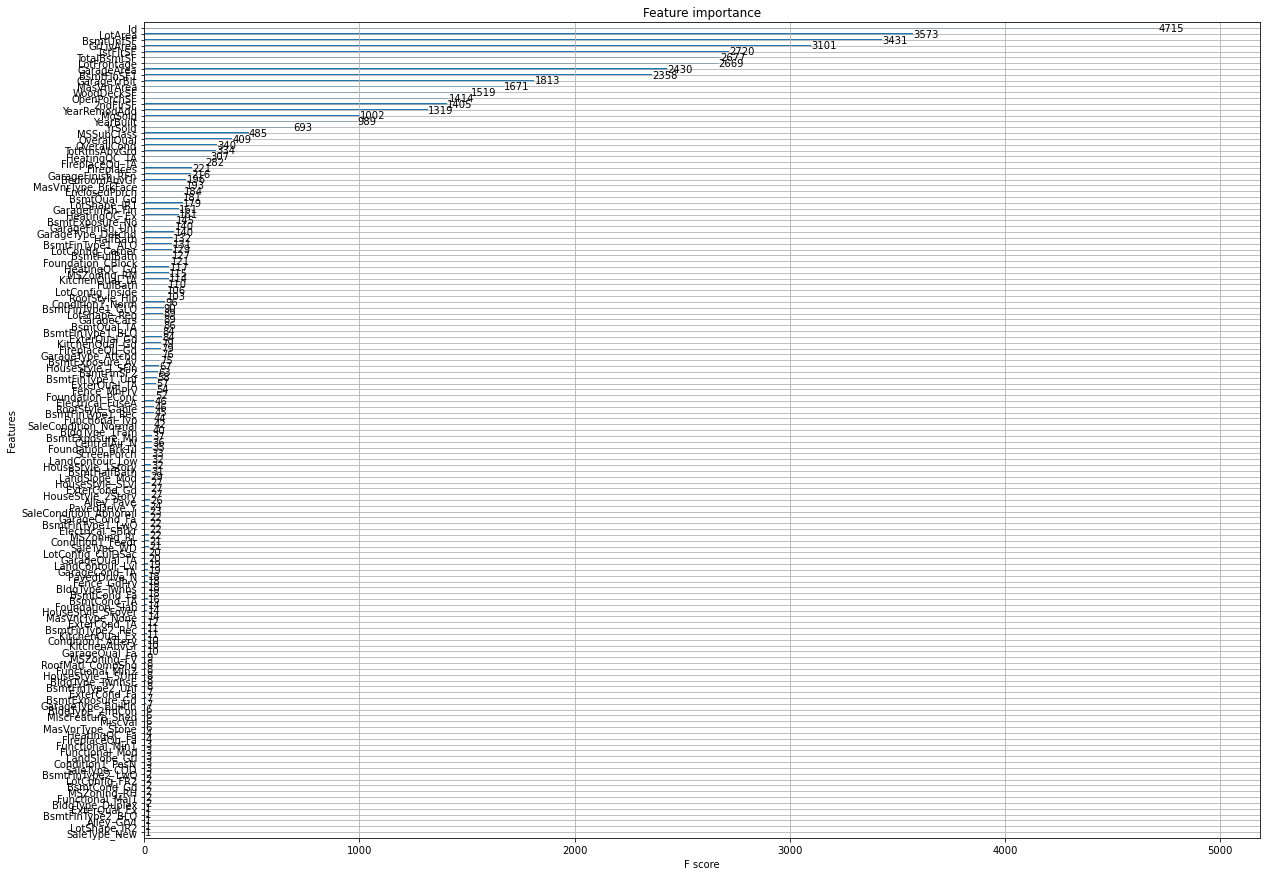

In [66]:
classifier.fit(X_train_xg, y_train)
class_pred = classifier.predict(X_valid_xg)
plt.figure(figsize=(100,15))
xgb.plot_importance(classifier, ax=plt.gca())